# core

> Fill in a module description here

In [ ]:
# | default_exp core

In [ ]:
# | hide
from nbdev.showdoc import *

## Imports

In [ ]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.figure_format = 'retina'
import datetime
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set()
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = 10, 6
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.precision = 4
warnings.simplefilter(action="ignore", category=FutureWarning)

dollar_formatter = FuncFormatter(lambda x, pos: f"${x:,.0f}")
thousands_formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")

## Data

In [ ]:
canada_births_1991_2022 = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-01-09/canada_births_1991_2022.csv"
)
nhl_player_births = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-01-09/nhl_player_births.csv"
)
nhl_rosters = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-01-09/nhl_rosters.csv"
)
nhl_teams = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-01-09/nhl_teams.csv"
)

## Functions

In [ ]:
def filter_canadian_players(df):
    return df[df["birth_country"] == "CAN"]



def linear_weight(month):
    # Assuming month is an integer from 1 (January) to 12 (December)
    return month


def logistic_weight(month, midpoint=6.5, growth_rate=1, max_value=12):
    return max_value / (1 + np.exp(-growth_rate * (month - midpoint)))


def calculate_metric(birth_months, weight_function):
    weighted_sum = sum(weight_function(month) for month in birth_months)
    return weighted_sum / len(birth_months)

def raw_to_cleaned_canada(df_):
    return df_.assign(yearmonth=pd.to_datetime(df_[["year", "month"]].assign(day=1)))




def raw_to_cleaned_nhl_player_births(df_):
    return df_.assign(birth_date=pd.to_datetime(df_["birth_date"]))

def simulate_player_birth_skew(n_players=100, n_simulations=10):
    """
    Simulate the player birth skew by randomly selecting birth months based on the Canadian birth rate.

    Parameters:
    - n_players (int): Number of players to simulate. Default is the size of nhl_player_births.
    - n_simulations (int): Number of simulations to run. Default is 10.

    Returns:
    - weights (ndarray): An array containing the calculated metric for each simulation.
    """

    # Initialize an empty list to store the calculated metric for each simulation
    weights = []

    # Run the simulations
    for sim in range(n_simulations):
        # Randomly select birth months based on the Canadian birth rate
        birth_months = np.random.choice(
            canadian_births_percentage.index,
            p=canadian_births_percentage.values / 100,
            replace=True,
            size=n_players,
        )

        # Calculate the metric using the linear weight function
        weight = calculate_metric(birth_months, linear_weight)

        # Append the calculated metric to the list
        weights.append(weight)

    return np.array(weights)

In [ ]:
canadian_players_by_birth = filter_canadian_players(nhl_player_births)
clean_canada_births = raw_to_cleaned_canada(canada_births_1991_2022)
clean_nhl_player_births = raw_to_cleaned_nhl_player_births(nhl_player_births)


canadian_births_percentage = (
    clean_canada_births.groupby("month")["births"].sum()
    / clean_canada_births["births"].sum()
    * 100.0
)

## EDA

In [ ]:
n_players = nhl_player_births["player_id"].nunique()

## Plots

### What does the birth rate for Canadians look like (agg monthly)?

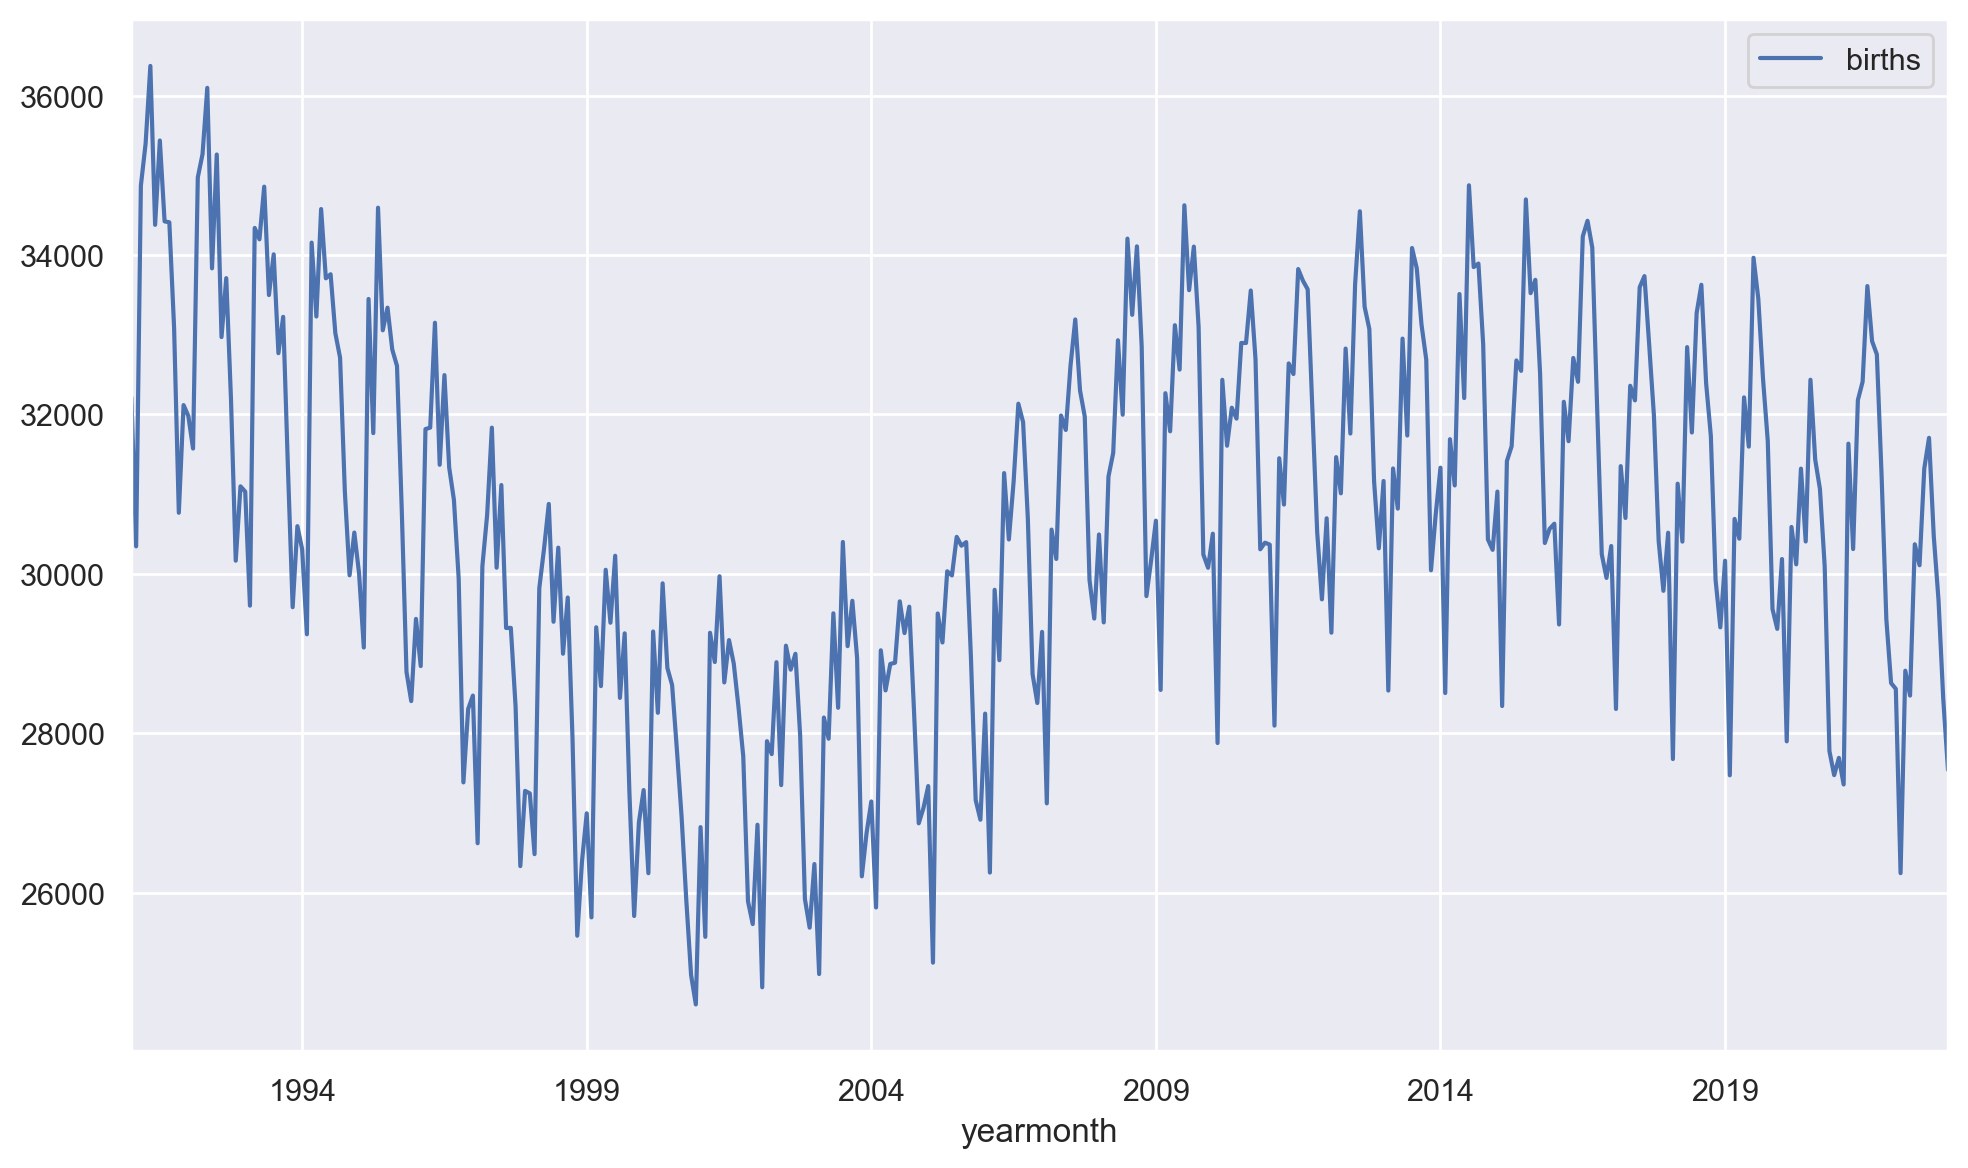

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")
clean_canada_births.plot(x="yearmonth", y="births", ax=ax)
fig.tight_layout()

In [ ]:
clean_canada_births.head()

,year,month,births,yearmonth
0,1991,1,32213,1991-01-01
1,1991,2,30345,1991-02-01
2,1991,3,34869,1991-03-01
3,1991,4,35398,1991-04-01
4,1991,5,36371,1991-05-01


In [ ]:
clean_canada_births.tail()

,year,month,births,yearmonth
379,2022,8,31706,2022-08-01
380,2022,9,30472,2022-09-01
381,2022,10,29671,2022-10-01
382,2022,11,28428,2022-11-01
383,2022,12,27540,2022-12-01


In [ ]:
# Check if the sum of Canadian births percentage is close to 100
assert np.isclose(canadian_births_percentage.sum(), 100.0)

### What does the monthly birth rate for Canadians look like?

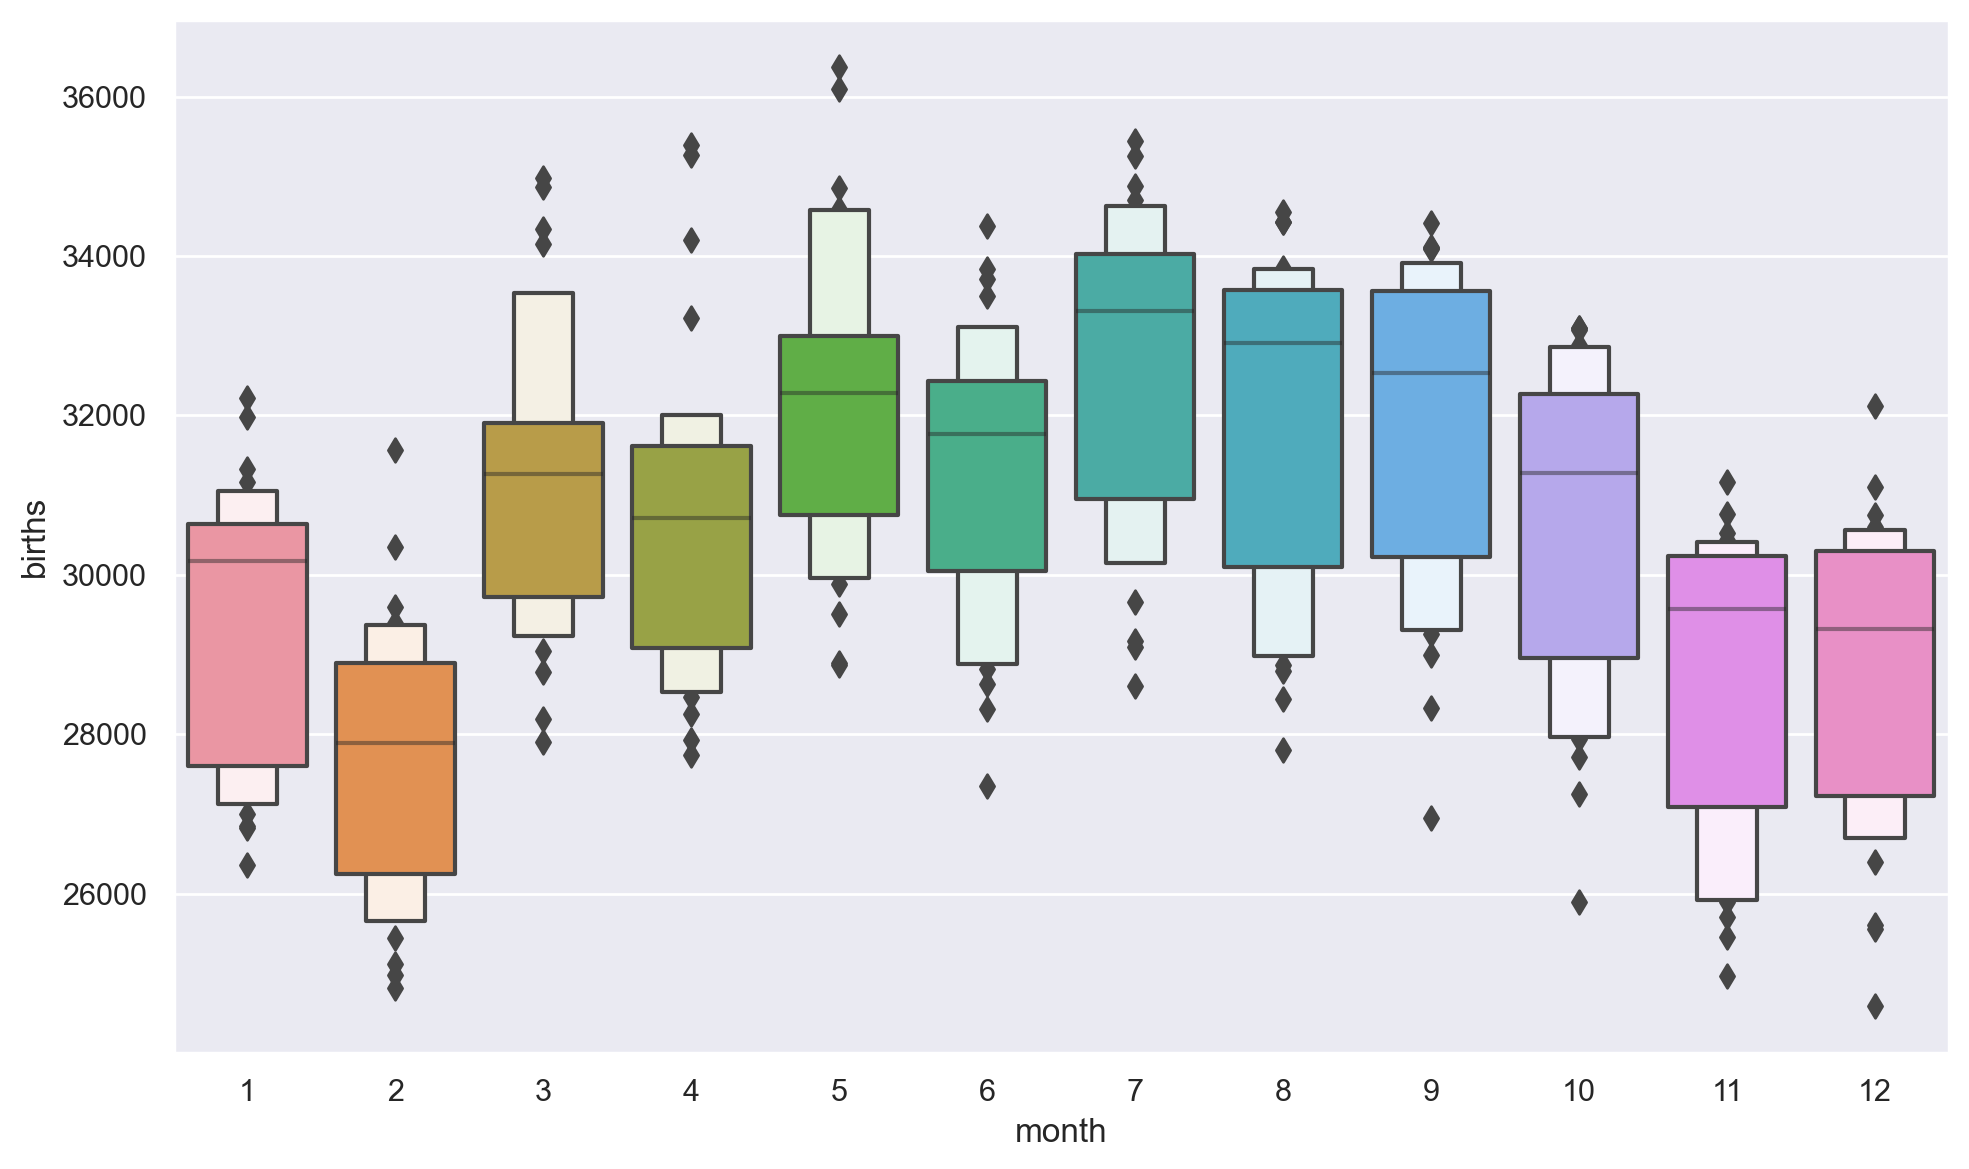

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")
sns.boxenplot(data=clean_canada_births, ax=ax, x="month", y="births")
fig.tight_layout()

### What does the monthly birth rate for NHL players look like?

In [ ]:
clean_nhl_player_births.head()[["player_id", "birth_month"]]

,player_id,birth_month
0,8467867,3
1,8445176,9
2,8460014,4
3,8460510,5
4,8459596,8


In [ ]:
g = clean_nhl_player_births.groupby(["birth_month"]).count()["player_id"]

In [ ]:
month_counts = clean_nhl_player_births["birth_month"].value_counts().sort_index()

In [ ]:
month_counts

# Create a DataFrame for plotting
plot_data = pd.DataFrame(
    {"Month": month_counts.index, "Player Count": month_counts.values}
)

# Create the boxenplot

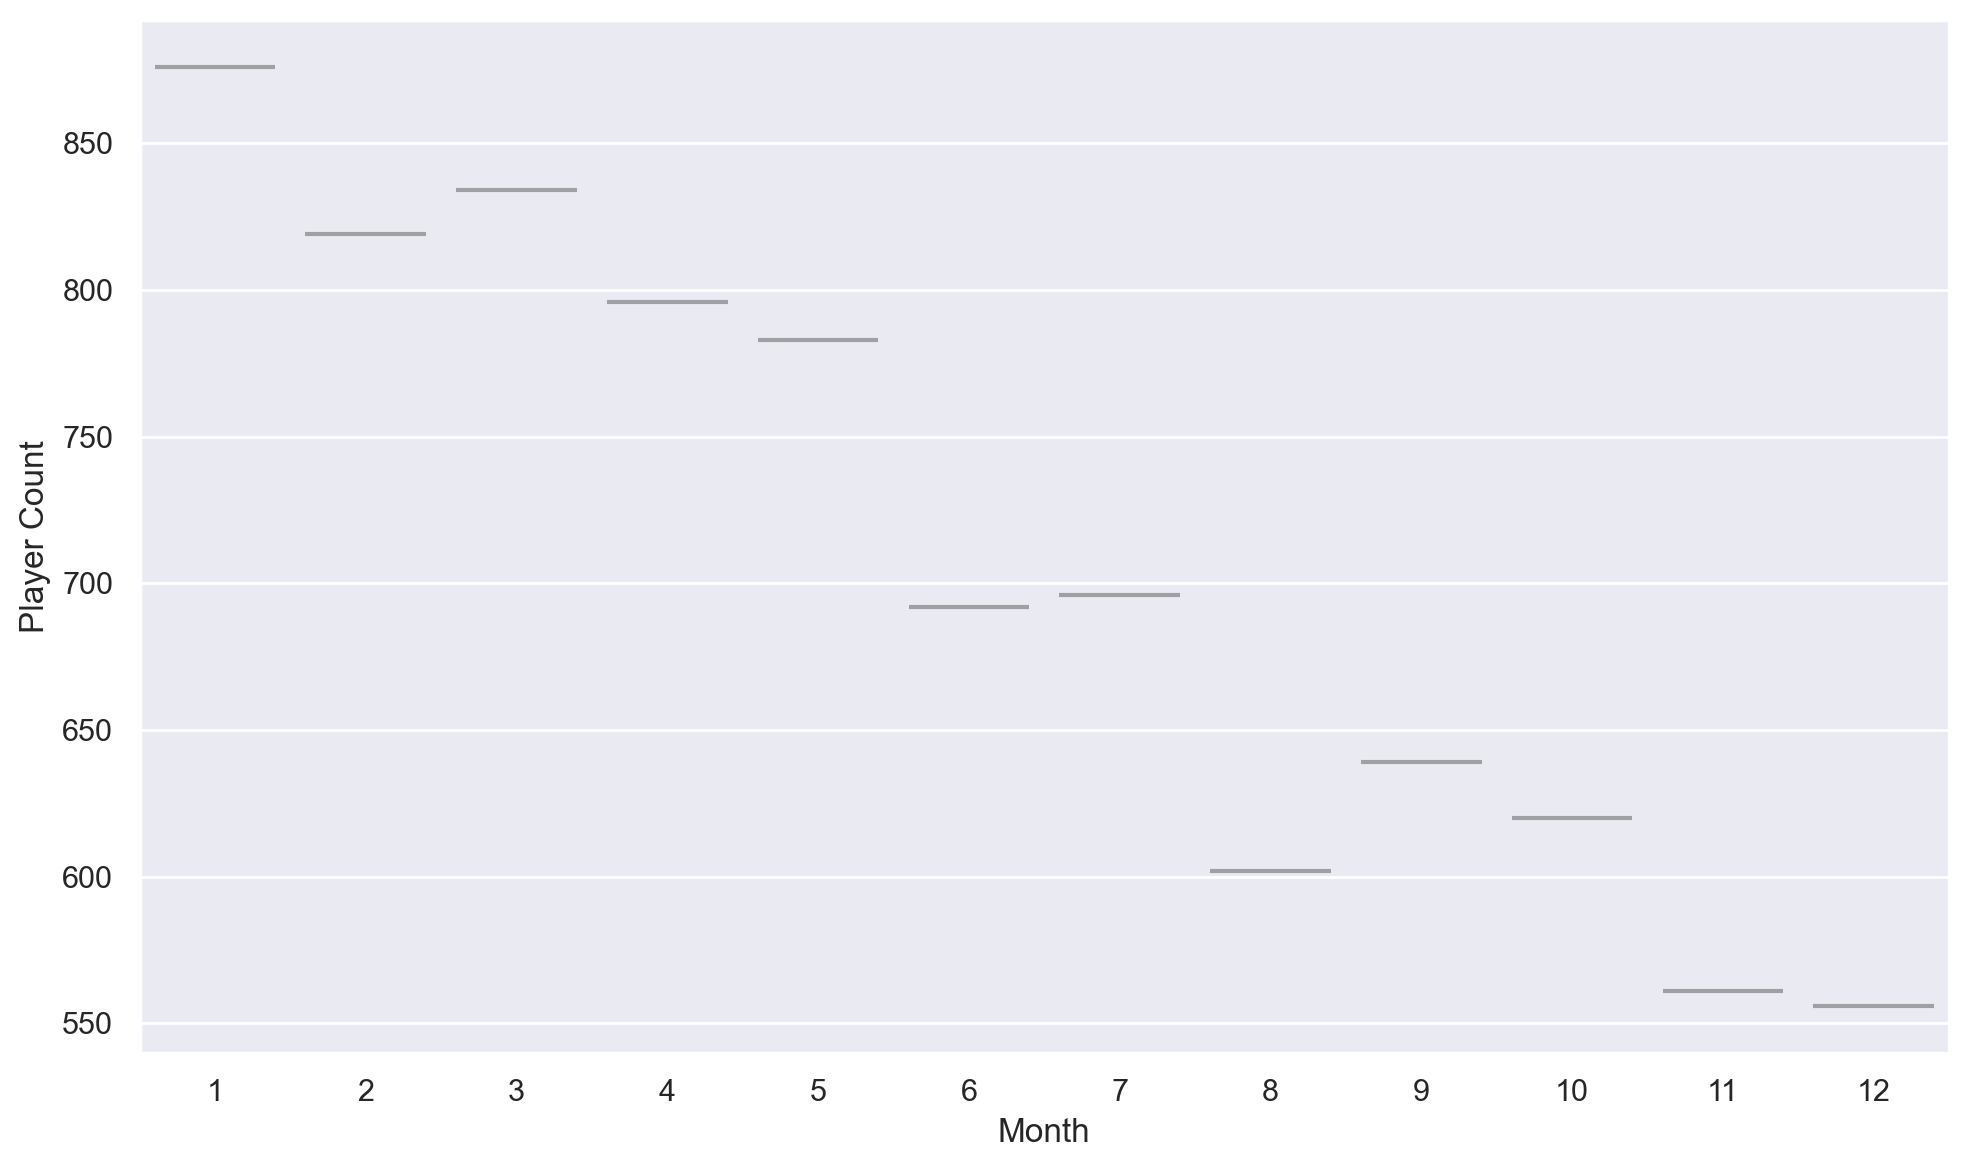

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")
sns.boxenplot(x="Month", y="Player Count", data=plot_data, ax=ax)
# ax.xaxis.set_major_formatter(dollar_formatter)
fig.tight_layout()

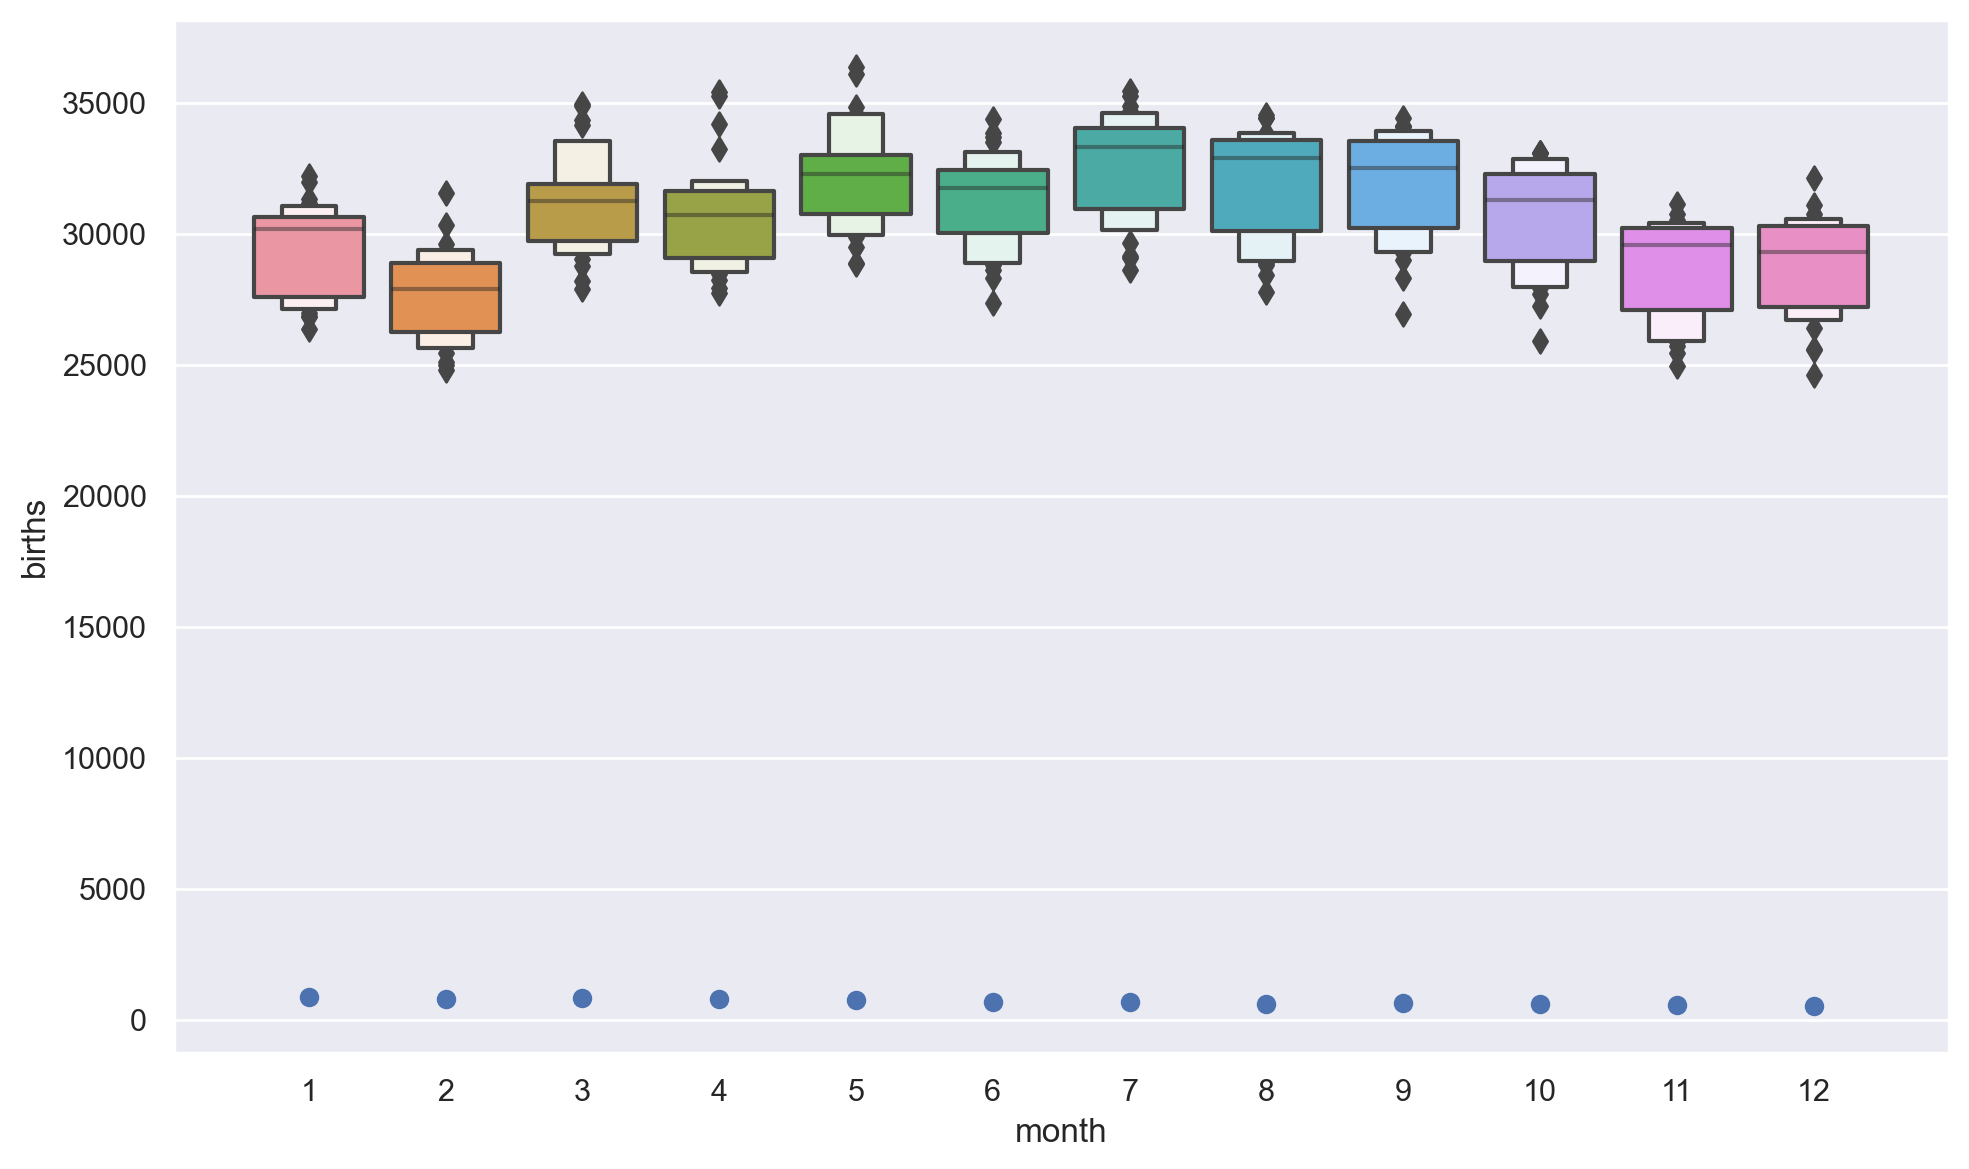

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")
sns.boxenplot(data=clean_canada_births, ax=ax, x="month", y="births")
ax.scatter(g.index - 1, g)
fig.tight_layout()

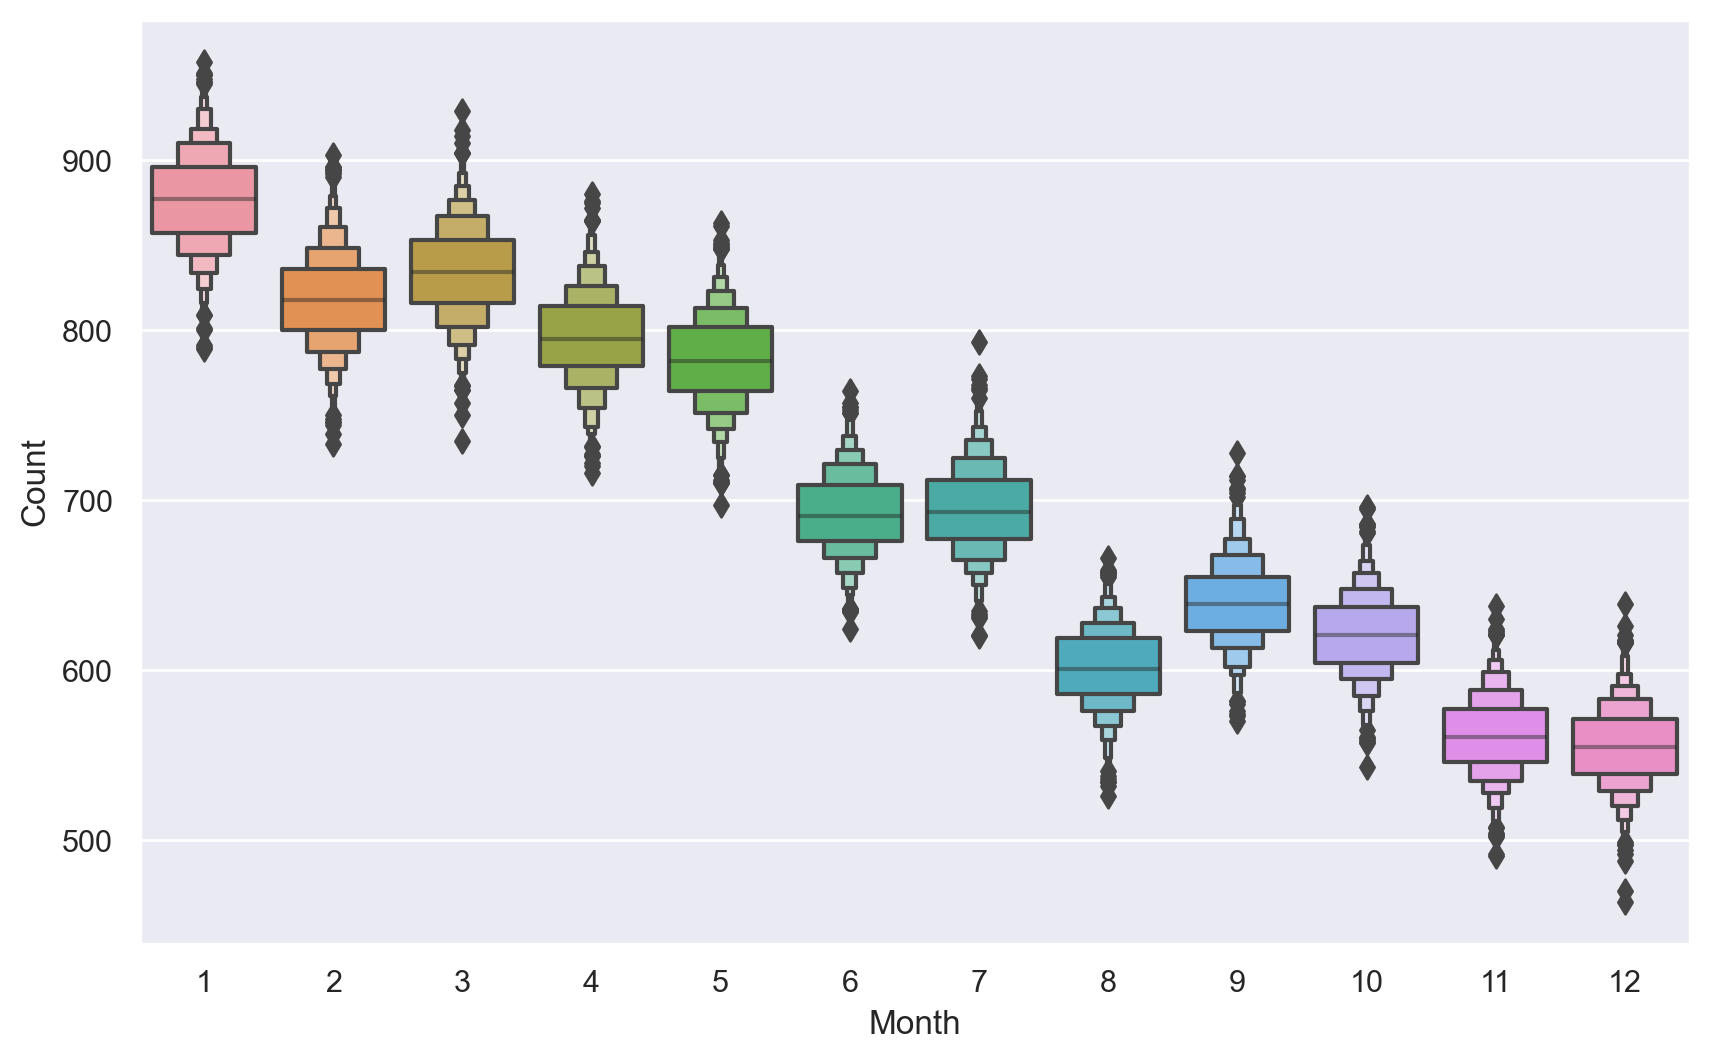

In [ ]:
# Number of bootstrap iterations
n_iterations = 1000

# List to store bootstrap samples
bootstrap_samples_list = []

for i in range(n_iterations):
    # Sample the entire dataset with replacement
    sample = clean_nhl_player_births.sample(frac=1, replace=True)
    # Count the number of players for each month in the sample
    month_counts = sample["birth_month"].value_counts().sort_index()
    # Store the counts with the month information
    for month in month_counts.index:
        bootstrap_samples_list.append({"Month": month, "Count": month_counts[month]})

# Concatenate all samples into a DataFrame
bootstrap_samples = pd.concat(
    [pd.DataFrame([sample]) for sample in bootstrap_samples_list], ignore_index=True
)

# Now plot the data
sns.boxenplot(x="Month", y="Count", data=bootstrap_samples)
plt.show()

# NHL players are preferentially born "early" in the year

### Define early in the year

Each month gets its numerical value as it's "weight". January -> 1, December -> 12.

### Create a metric

A linear weighting of the months that appear in a data set.

### Simulate

I will draw from the NHL players roster; and I will randomly draw from the general Canadian population birth month distribution. Do this process 10,000 times. Create a distribution of the metric. 

### Compare


### Visualize


In [ ]:
weights = simulate_player_birth_skew(
    n_players=canadian_players_by_birth["player_id"].nunique(), n_simulations=1000
)

In [ ]:
# todo add test that early and late years have different metric values

assert calculate_metric(np.random.randint(1, 8, size=100), linear_weight)  < 6.5
assert calculate_metric(np.random.randint(5, 12, size=100), linear_weight) > 6.5

In [ ]:
weights = simulate_player_birth_skew(
    n_players=canadian_players_by_birth["player_id"].nunique(), n_simulations=10_000
)

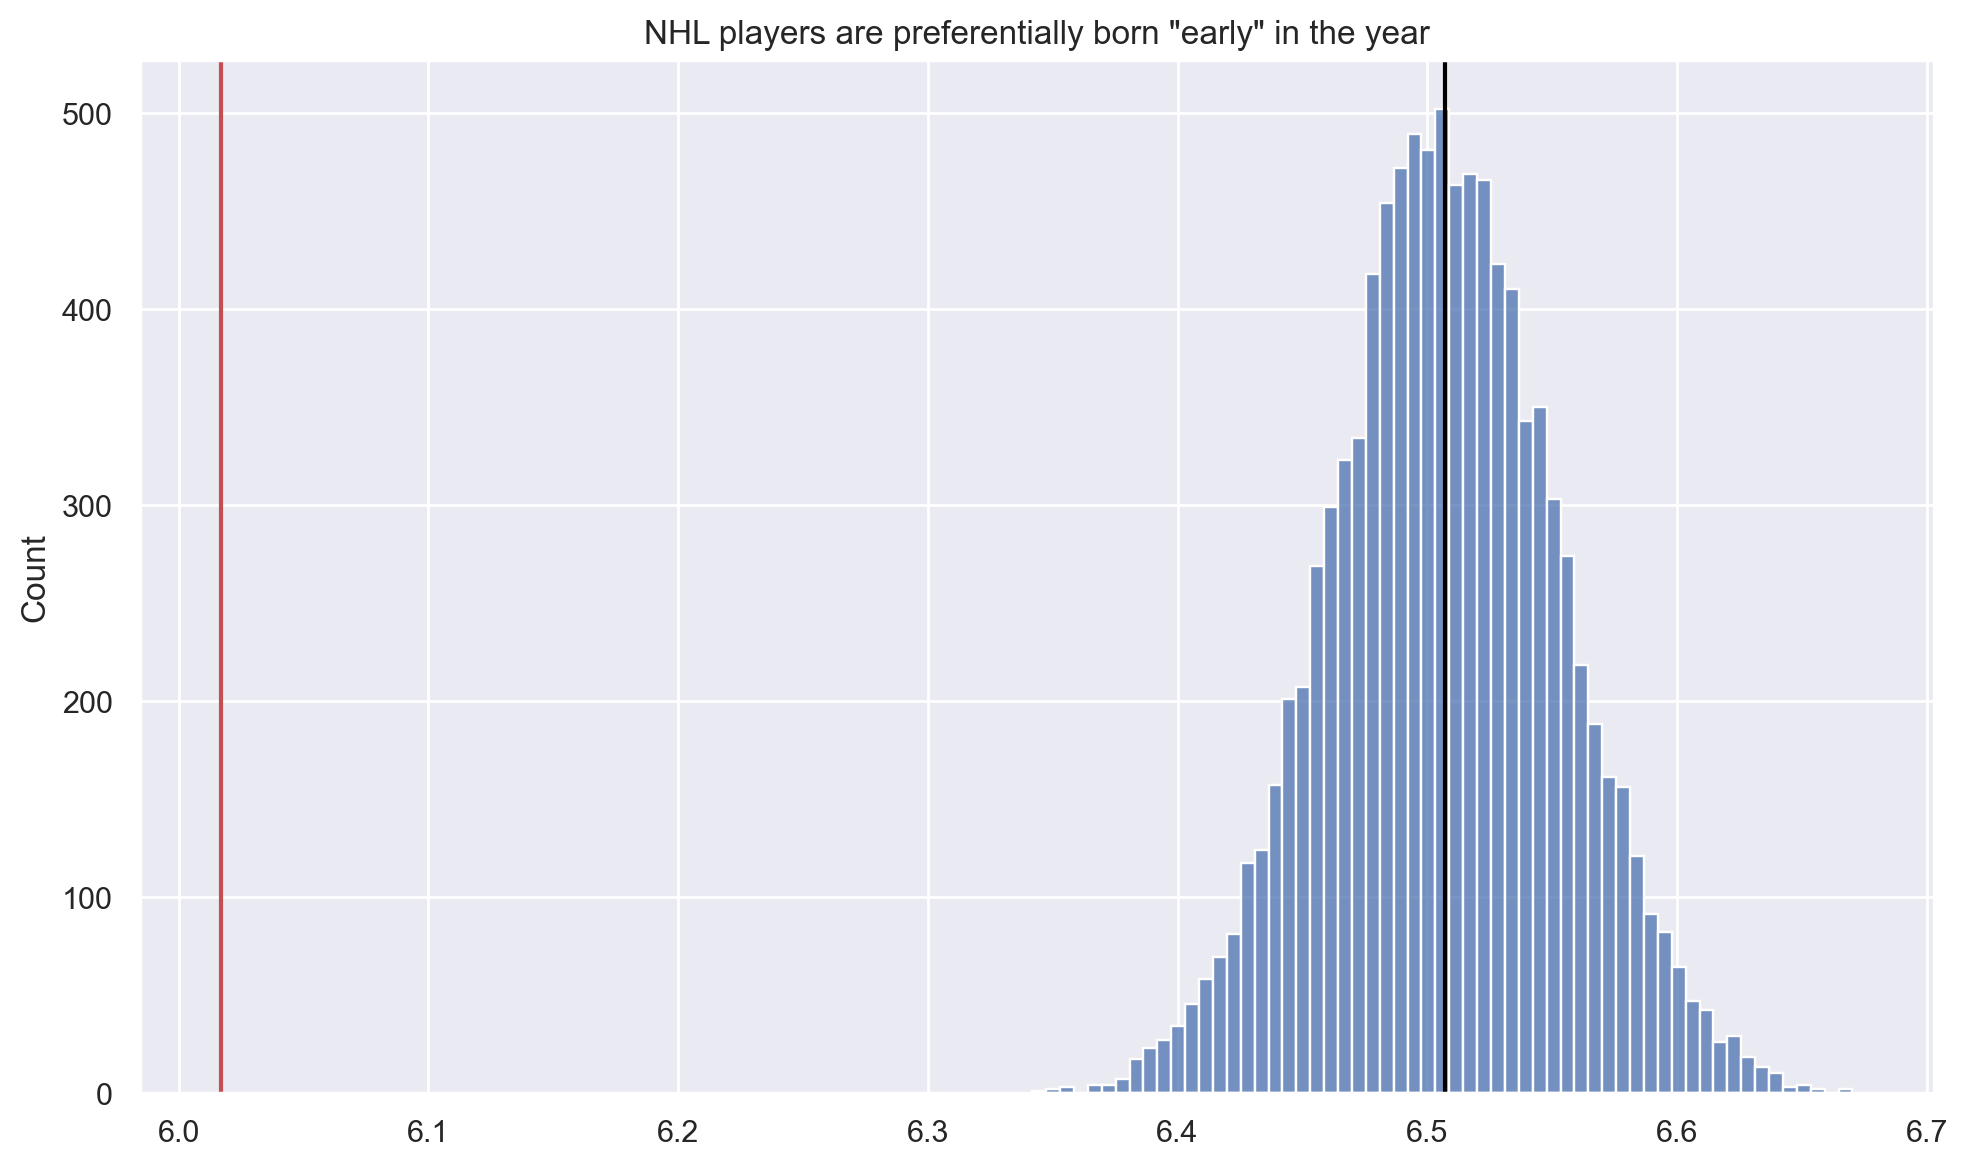

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")
sns.histplot(weights, ax=ax)
ax.axvline(
    calculate_metric(canadian_players_by_birth["birth_month"], linear_weight),
    color=sns.color_palette()[3],
)
ax.axvline(
    np.average(weights), # if perfectly balanced 
    color='black',
)
ax.set_title(f'NHL players are preferentially born "early" in the year')
fig.tight_layout()

### Reproduce the visual

## Questions

- Should I exclusively look at NHL players born in Canada?
- Should I weight the overall Canada birth rate based on NHL player density?
    - I think yes, and I can do it by sampling based on player's birth year.
- Should I slice active players by season (year)? As in, over time is the effect changing?

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()